<a href="https://colab.research.google.com/github/mastersigat/GeoPandas/blob/main/S%C3%A9ance_4_Analyse_Spatiale_Urbanisme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séance 5 - Analyses spatiales de données urbanistiques

# Configuration environnement de travail

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install geopandas
# Install Fiona
!pip install Fiona
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie interactive
!pip install folium
# Install scalebar
!pip install matplotlib_scalebar

In [ ]:
#Importation des librairies nécessaires
import pandas as pd #Gestion de données
import matplotlib as plt #Visualisation de données
import geopandas as gpd #Gestion données spatiales
import pygeos #Opérations sur les géométrie de données spatiales
import contextily as ctx #Fonds de carte
import fiona as np #lecture et écriture de données spatiales
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import folium #Cartographie interactive
import mapclassify #Cartographie thématique
from matplotlib_scalebar.scalebar import ScaleBar #Echhelle cartographique


# Importation des données (cadastre.data.gouv.fr)

Nous travaillons ici sur la commune de Cesson Sévigné (code insee 35051)

In [ ]:
#Téléchargement des datas depuis cadastre.data.gouv
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/batiments -O batiments.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/parcelles -O parcelles.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/sections -O sections.zip

,id,commune,prefixe,code,created,updated,geometry
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6..."
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6..."
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6..."


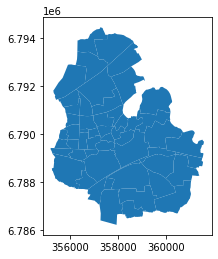

In [76]:
#Chargement couche des Sections cadastrales

Sections= gpd.read_file("sections.zip", encoding='utf-8')
Sections.plot()
Sections.head(3)

,id,commune,prefixe,section,numero,contenance,created,updated,geometry
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6..."
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6..."
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6..."


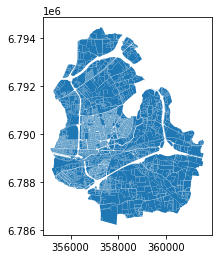

In [77]:
#Chargement couche des Parcelles

Parcelles= gpd.read_file("parcelles.zip", encoding='utf-8')
Parcelles.plot()
Parcelles.head(3)

In [89]:
#Compter le nombre de parcelles
len(Parcelles)

9002

,commune,nom,type,created,updated,geometry
0,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6..."


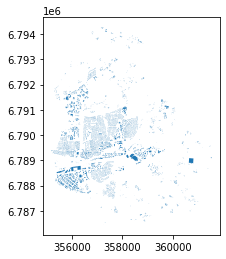

In [79]:
#Chargement couche des Batiments

Batiments= gpd.read_file("batiments.zip", encoding='utf-8')
Batiments.plot()
Batiments.head(3)

In [80]:
#Compter le nombre de batiments
len(Batiments)

9041

# Préparation des couches

In [101]:
# Vérifier le SCR des couches

Batiments.crs
Parcelles.crs
Sections.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [102]:
#Créer un ID unique pour chaque batiment (id unique)

Batiments["ID_Bati"] = Batiments.index
Batiments.head()

,commune,nom,type,created,updated,geometry,ID_Bati
0,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0
1,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1
2,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2
3,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357201.063 6790536.791, 357202.418 6...",3
4,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357170.131 6790496.341, 357177.821 6...",4


In [103]:
# Créer un ID unique pour chaque parcelle (concaténation de deux champs)

Parcelles["ID_Parcelle"] = Parcelles["prefixe"] + "-" + Parcelles["section"] + "-" + Parcelles["numero"]
Parcelles.head(3)

,id,commune,prefixe,section,numero,contenance,created,updated,geometry,ID_Parcelle
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6...",000-AA-562
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6...",000-AA-564
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6...",000-AA-563


In [104]:
# Créer un ID unique pour chaque section (concaténation de deux champs)

Sections["ID_Section"] = Sections["prefixe"] + "-" + Sections["code"]
Sections.head(3)

,id,commune,prefixe,code,created,updated,geometry,ID_Section
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6...",000-AA
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6...",000-AB
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6...",000-AC


In [105]:
# Ajouter une colonne surface aux sections cadastrales (entier)

Sections["Surface_Section"] = Sections['geometry'].area
Sections["Surface_Section"] = Sections["Surface_Section"].astype(int)
Sections.head(3) 

,id,commune,prefixe,code,created,updated,geometry,ID_Section,Surface_Section
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6...",000-AA,369064
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6...",000-AB,214286
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6...",000-AC,142503


In [106]:
# Ajouter une colonne surface aux parcelles cadastrales (entier)

Parcelles["Surface_Parcelle"] = Parcelles['geometry'].area
Parcelles["Surface_Parcelle"] = Parcelles["Surface_Parcelle"].astype(int)
Parcelles.head(3) 

,id,commune,prefixe,section,numero,contenance,created,updated,geometry,ID_Parcelle,Surface_Parcelle
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6...",000-AA-562,42589
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6...",000-AA-564,23922
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6...",000-AA-563,5647


In [107]:
# Ajouter une colonne surface aux batiments

Batiments["Surface_Batiment"] = Batiments['geometry'].area
Batiments["Surface_Batiment"] = Batiments["Surface_Batiment"].astype(int)
Batiments.head(3) 

,commune,nom,type,created,updated,geometry,ID_Bati,Surface_Batiment
0,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0,100
1,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1,92
2,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2,114


<Axes: >

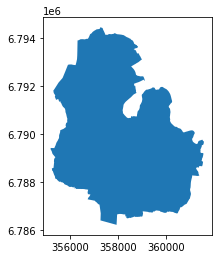

In [108]:
# Créer une couche avec l'emprise de Cesson

Cesson = Sections.dissolve(by="commune")
Cesson.plot()

# Analyses spatiales

*   Compter le nombre de bâtiments par section cadastrale
*   Compter le nombre de bâtiments par parcelle cadastrale
*   Calculer la proportion de surface des bâtiments par parcelle cadastrale 

## Compter le nombre de bâtiments par section cadastrale


,commune,nom,type,created,updated,geometry,ID_Bati,Surface_Batiment
0,35051,NaN,01,2020-06-16,2020-06-22,POINT (357214.927 6790493.368),0,100
1,35051,NaN,01,2020-06-16,2020-06-22,POINT (357186.831 6790466.391),1,92
2,35051,NaN,01,2020-06-16,2020-06-22,POINT (357216.900 6790398.322),2,114


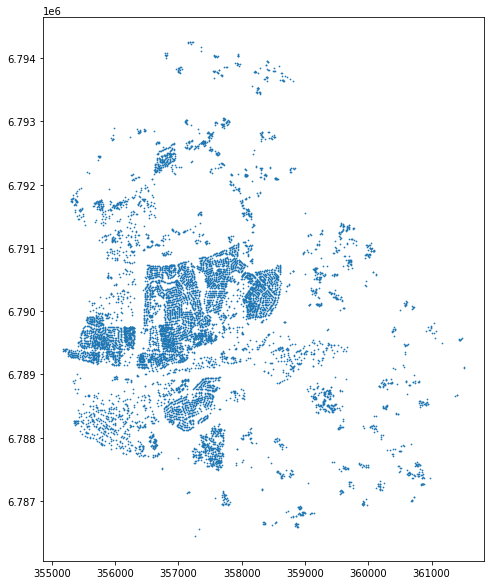

In [109]:
#Transformer les batiments (polygones) en points (centroides)

BatimentsCentro = Batiments.copy()
BatimentsCentro.geometry = BatimentsCentro['geometry'].centroid
BatimentsCentro.crs =Batiments.crs
BatimentsCentro.plot(figsize=(300,10), markersize=0.5, legend=True)
BatimentsCentro.head(3)

In [110]:
# Encrichir les batiments des informations de la couche des Sections Cadastrales (jointure spatiale)

BatimentsEtape1 = gpd.sjoin(BatimentsCentro, Sections)
BatimentsEtape1.head(5)

,commune_left,nom,type,created_left,updated_left,geometry,ID_Bati,Surface_Batiment,index_right,id,commune_right,prefixe,code,created_right,updated_right,ID_Section,Surface_Section
0,35051,NaN,01,2020-06-16,2020-06-22,POINT (357214.927 6790493.368),0,100,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064
1,35051,NaN,01,2020-06-16,2020-06-22,POINT (357186.831 6790466.391),1,92,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064
2,35051,NaN,01,2020-06-16,2020-06-22,POINT (357216.900 6790398.322),2,114,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064
3,35051,NaN,01,2020-06-16,2020-06-22,POINT (357196.770 6790531.821),3,139,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064
4,35051,NaN,01,2020-06-16,2020-06-22,POINT (357176.881 6790496.643),4,107,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064


In [111]:
#Réorganiser la table

BatimentsEtape2 = BatimentsEtape1[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "geometry"]]
BatimentsEtape2.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,geometry
0,0,01,AA,100,000-AA,369064,POINT (357214.927 6790493.368)
1,1,01,AA,92,000-AA,369064,POINT (357186.831 6790466.391)
2,2,01,AA,114,000-AA,369064,POINT (357216.900 6790398.322)


In [112]:
# Encrichir les batiments des informations de la couche des parcelles Cadastrales (jointure spatiale)

BatimentsEtape3 = gpd.sjoin(BatimentsEtape2, Parcelles)
BatimentsEtape3.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,geometry,index_right,id,commune,prefixe,section,numero,contenance,created,updated,ID_Parcelle,Surface_Parcelle
0,0,01,AA,100,000-AA,369064,POINT (357214.927 6790493.368),15,35051000AA0126,35051,000,AA,126,580.0,2020-06-16,2021-01-29,000-AA-126,584
1,1,01,AA,92,000-AA,369064,POINT (357186.831 6790466.391),14,35051000AA0124,35051,000,AA,124,468.0,2020-06-16,2021-01-29,000-AA-124,470
2,2,01,AA,114,000-AA,369064,POINT (357216.900 6790398.322),22,35051000AA0119,35051,000,AA,119,513.0,2020-06-16,2021-01-29,000-AA-119,511


In [113]:
#Réorganiser la table

BatimentsFinal = BatimentsEtape3[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry"]]
BatimentsFinal.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,geometry
0,0,01,AA,100,000-AA,369064,000-AA-126,584,POINT (357214.927 6790493.368)
1,1,01,AA,92,000-AA,369064,000-AA-124,470,POINT (357186.831 6790466.391)
2,2,01,AA,114,000-AA,369064,000-AA-119,511,POINT (357216.900 6790398.322)


In [114]:
# Jointure attributaire pour repasser sur la couche des polygones

BatimentsFinalOk = Batiments.merge(BatimentsFinal, on='ID_Bati')
BatimentsFinalOk.head(3)

,commune,nom,type_x,created,updated,geometry_x,ID_Bati,Surface_Batiment_x,type_y,code,Surface_Batiment_y,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,geometry_y
0,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0,100,01,AA,100,000-AA,369064,000-AA-126,584,POINT (357214.927 6790493.368)
1,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1,92,01,AA,92,000-AA,369064,000-AA-124,470,POINT (357186.831 6790466.391)
2,35051,NaN,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2,114,01,AA,114,000-AA,369064,000-AA-119,511,POINT (357216.900 6790398.322)


In [115]:
#Réorganiser la table
BatimentsFinalOk = BatimentsFinalOk[["ID_Bati", "type_x", "Surface_Batiment_x", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry_x"]]
BatimentsFinalOk.rename(columns={'type_x': 'type','Surface_Batiment_x': 'Surface_Batiment','geometry_x': 'Geometry'}, inplace=True)
BatimentsFinalOk.head()

,ID_Bati,type,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,Geometry
0,0,01,100,000-AA,369064,000-AA-126,584,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,1,01,92,000-AA,369064,000-AA-124,470,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,2,01,114,000-AA,369064,000-AA-119,511,"POLYGON ((357208.471 6790399.177, 357213.178 6..."
3,3,01,139,000-AA,369064,000-AA-78,669,"POLYGON ((357201.063 6790536.791, 357202.418 6..."
4,4,01,107,000-AA,369064,000-AA-82,577,"POLYGON ((357170.131 6790496.341, 357177.821 6..."


,ID_Bati,type,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,Geometry
0,0,01,100,000-AA,369064,000-AA-126,584,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,1,01,92,000-AA,369064,000-AA-124,470,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,2,01,114,000-AA,369064,000-AA-119,511,"POLYGON ((357208.471 6790399.177, 357213.178 6..."


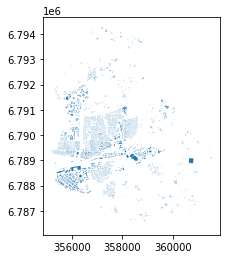

In [116]:
#Repasser en GeoDataframe

BatiOK = gpd.GeoDataFrame(BatimentsFinalOk, crs="EPSG:2154", geometry='Geometry')
BatiOK.plot()
BatiOK.head(3)


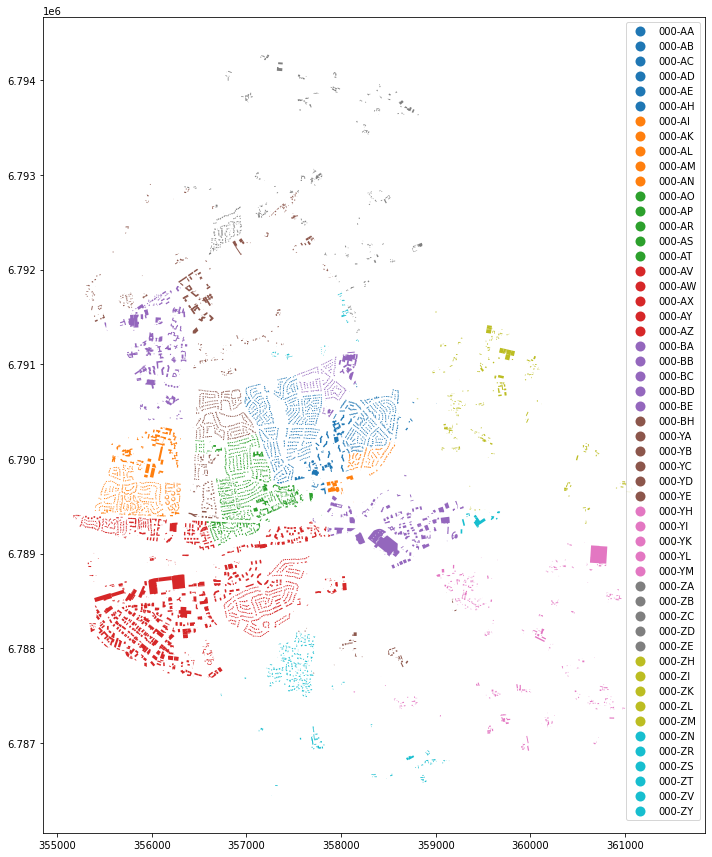

In [117]:
# Faire une carte des batiments catégorisée par code de section

map2 = BatiOK.plot(figsize=(15,15), column='ID_Section', legend=True).get_figure()

In [118]:
# Calculer le  nombre de batiments par sections cadastrale

NbBatiSection = BatiOK[["ID_Section", "ID_Bati"]].groupby("ID_Section").size()
NbBatiSection = pd.DataFrame(NbBatiSection)
NbBatiSection = NbBatiSection.rename(columns={0: 'NbBatis'})
NbBatiSection.head(3)

,NbBatis
ID_Section,
000-AA,475
000-AB,263
000-AC,112


In [119]:
# Compter le nombre de batiment (vérification)

total1 = Batiments['geometry'].count()
total2 = NbBatiSection['NbBatis'].sum()
print(total1)
print(total1)

TypeError: ignored

In [ ]:
# Jointure attributaire pour repasser sur la couche des sections cadastrales

Sections = Sections.merge(NbBatiSection, on='ID_Section')
Sections.head(3)

In [ ]:
# Faire une carte pour représenter le nombre de batiments pas section cadastrale

SectionsCentro = Sections.copy()
SectionsCentro.geometry = SectionsCentro['geometry'].centroid

map3, ax = plt.pyplot.subplots(figsize=(10,10))
Sections.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.4)
SectionsCentro.plot(ax=ax,color="#ee0db1", markersize="NbBatis",alpha=0.7, categorical=False, legend=True)
ax.axis("off")
plt.pyplot.show()

In [ ]:
# Histogramme

NbBatiSection.plot.hist(figsize = (10,5), bins=50, edgecolor='white')

## Compter le nombre de bâtiments par parcelle cadastrale

In [ ]:
# Calculer le Nombre de batiments par parcelle cadastrale

NbBatiParcelle  = BatiOK[["ID_Parcelle", "ID_Bati"]].groupby("ID_Parcelle").size()
NbBatiParcelle =pd.DataFrame(NbBatiParcelle)
NbBatiParcelle = NbBatiParcelle.rename(columns={0: 'NbBatis'})
NbBatiParcelle.head(5)

In [ ]:
# Compter le nombre de batiment

total1 = Batiments['geometry'].count()
total2 = NbBatiParcelle['NbBatis'].sum()
print(total1)
print(total1)

In [ ]:
# Jointure attributaire pour repasser sur la couche des parcelles  cadastrales

Parcellesbis = Parcelles.merge(NbBatiParcelle, on='ID_Parcelle')
Parcellesbis.head(3)

In [ ]:
# Faire une carte pour représenter le nombre de batiments par parcelle cadastrale

Parcellescentro = Parcellesbis.copy()
Parcellescentro.geometry = Parcellescentro['geometry'].centroid

map4, ax = plt.pyplot.subplots(figsize=(16,16))
Parcelles.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.1)
Parcellescentro.plot(ax=ax, markersize="NbBatis", color='red', alpha=0.7, legend=True)
ax.axis("off")
plt.pyplot.show()

In [ ]:
#Histogramme 

NbBatiParcelle.plot.hist(figsize = (10,5), bins=50, edgecolor='white')

## Calculer la proportion de surface des bâtiments par parcelle cadastrale (tx de recouvrement)

In [ ]:
BatiOK.head(3)

In [ ]:
# Calculer la proportion des surfaces baties par parcelle cadastrale

recap = BatiOK.groupby('ID_Parcelle').agg({'Surface_Batiment':'sum','Surface_Parcelle':'max'})
recap["propbatiparcelle"] = recap["Surface_Batiment"] / recap["Surface_Parcelle"] *100
recap.head()

In [ ]:
# Faire la jointure attributaire avec la couche des parcelles cadastrales et la carte

Parcellesok = Parcellesbis.merge(recap, on='ID_Parcelle')
Parcellesok.head()

In [ ]:
# Faire la carte

map5, ax = plt.pyplot.subplots(figsize=(12,12))
Sections.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)
Parcelles.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.1)
Parcellesok.plot(ax=ax, column='propbatiparcelle', cmap='Spectral_r',scheme='quantiles', legend=True)
ax.axis("off")
plt.pyplot.show()

# Etude sur Cesson

In [ ]:
#Téléchargement des datas depuis le portail opendata de Rennes
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35047/shp/communes -O communes.zip
!wget -O hydrographie.geojson https://data.rennesmetropole.fr/explore/dataset/reseau_hydrographique/download/?format=geojson&timezone=Europe/Berlin&lang=fr
!wget -O PLU.geojson https://data.rennesmetropole.fr/explore/dataset/synthese_plui_2021/download/?format=geojson&timezone=Europe/Berlin&lang=fr

## Zonage et PLU 

<Axes: >

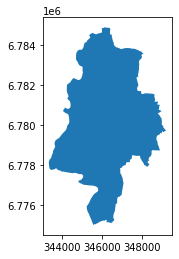

In [ ]:
#Chargement couche Cesson

Cesson= gpd.read_file("communes.zip", encoding='utf-8')
Cesson.plot()

,hydro_date_maj,objectid,deno_hydro_id,gml_id,hydro_code_insee,ope_id,type_hydro_id,type_hydro_nom,deno_hydr_nom,hydro_visible,geometry
0,NaN,113,1.0,v_hydro.113,35126.0,1.0,2,étang,NaN,1,"POLYGON ((363944.769 6775846.891, 363942.611 6..."
1,NaN,1302,1.0,v_hydro.1302,35040.0,1.0,2,étang,NaN,1,"POLYGON ((347618.971 6788557.940, 347588.783 6..."
2,NaN,2540,13.0,v_hydro.2540,35210.0,1.0,5,ruisseau,la Cocheriais,1,"POLYGON ((335883.720 6813559.168, 335878.868 6..."


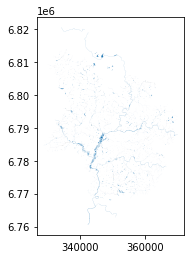

In [ ]:
#Chargement couche hydrographie

Hydrographie= gpd.read_file("hydrographie.geojson", encoding='utf-8')
Hydrographie = Hydrographie.to_crs("EPSG:2154")
Hydrographie.plot()
Hydrographie.head(3)

<Axes: >

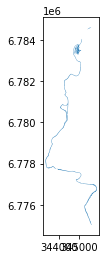

In [ ]:
# Ne garder que les troncons de tyoe "fleuve" dans la commune de Cesson

Fleuve = Hydrographie[(Hydrographie["type_hydro_nom"] == 'fleuve')]
HydroCessontrace = gpd.overlay(Fleuve, Cesson, how='intersection')
HydroCessontrace.plot()

,geometry,hydro_date_maj,objectid,deno_hydro_id,gml_id,hydro_code_insee,ope_id,type_hydro_id,type_hydro_nom,hydro_visible,id,nom,created,updated
deno_hydr_nom,,,,,,,,,,,,,,
la Vilaine,"POLYGON ((341957.858 6778716.468, 341970.573 6...",None,1554,2.0,v_hydro.1554,35238.0,1.0,3,fleuve,1,35047,BRUZ,2020-07-30,2021-03-25


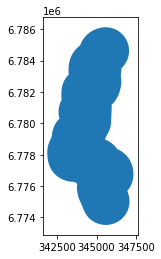

In [ ]:
#Faire un buffer de 500m autour de la couche hydro
HydroCesson = HydroCessontrace.copy()
HydroCesson['geometry'] = HydroCesson['geometry'].buffer(500)
HydroCesson = HydroCesson.dissolve(by ='deno_hydr_nom')
HydroCesson.plot()
HydroCesson.head()

,libelle,perimetre_geo,typezone,id_rm,gml_id,datevalid,aire_geo,objectid,semio,geometry
0,UC1,251.98,U,853,plui_synthese_2021.851,20200910,3644.41,851,NaN,"MULTIPOLYGON (((353235.723 6779204.293, 353232..."
1,UE2b,3317.53,U,858,plui_synthese_2021.856,20200910,208416.73,856,NaN,"MULTIPOLYGON (((347228.995 6780654.029, 347229..."
2,N,746.72,N,860,plui_synthese_2021.858,20200910,31503.09,858,NaN,"MULTIPOLYGON (((339853.642 6795564.836, 339860..."


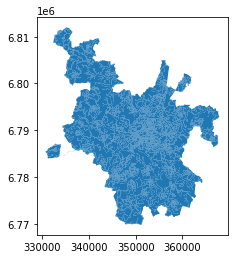

In [ ]:
#Chargement couche du PLU

PLU= gpd.read_file("PLU.geojson", encoding='utf-8')
PLU = PLU.to_crs("EPSG:2154")
PLU.plot()
PLU.head(3)

<Axes: >

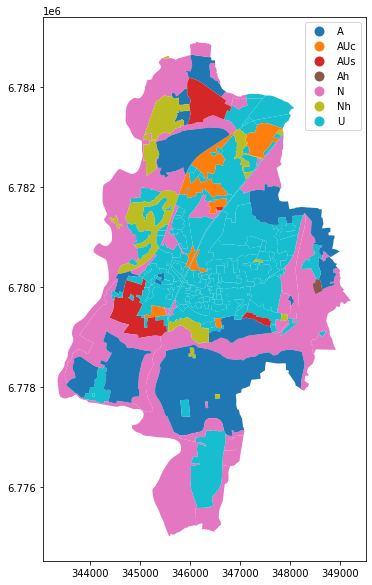

In [ ]:
#Ne garder sur le PLU de Cesson
PLUCesson = gpd.overlay(PLU, Cesson, how='intersection')
PLUCesson.plot(figsize=(10,10),column='typezone', legend=True)

<Axes: >

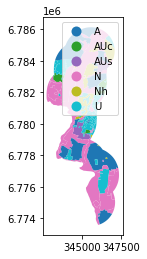

In [ ]:
# Garder le zonage situés à moins de 500m de la Vilaine
Zonagerisque = gpd.overlay(PLU, HydroCesson, how='intersection')
Zonagerisque.plot(column = 'typezone', legend = True)

--2023-03-17 18:21:18--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35047/shp/batiments
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-shapefile]
Saving to: ‘batiments.zip’

batiments.zip           [   <=>              ] 985.17K  1.78MB/s    in 0.5s    

2023-03-17 18:21:20 (1.78 MB/s) - ‘batiments.zip’ saved [1008809]



<Axes: >

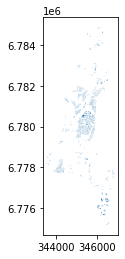

In [ ]:
# Garder les bâtiments situés à moins de 500m de la Vilaine

!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35047/shp/batiments -O batiments.zip
Batiments= gpd.read_file("batiments.zip", encoding='utf-8')
Batirisque = gpd.overlay(Batiments, HydroCesson, how='intersection')
Batirisque.plot()

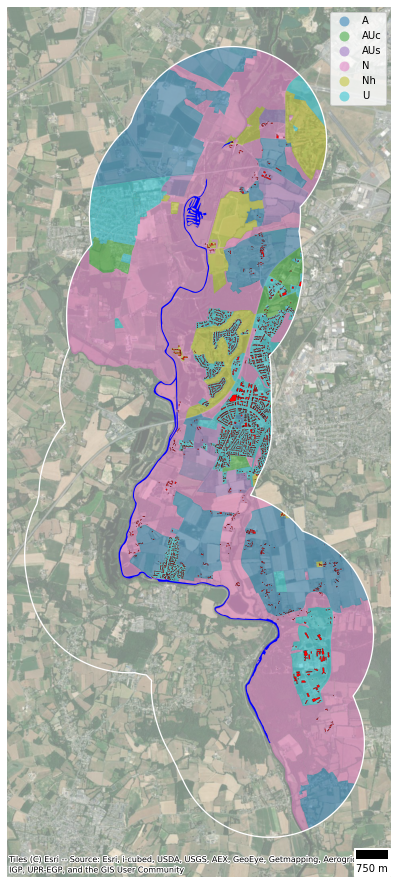

In [ ]:
#Carte récapitulative
map5, ax = plt.pyplot.subplots(figsize=(16,16))

HydroCesson.boundary.to_crs('EPSG:3857').plot(ax=ax, edgecolor="white", linewidth=1.3 )
Zonagerisque.to_crs('EPSG:3857').plot(ax = ax, column = 'typezone', legend = True, alpha=0.5)
Batirisque.to_crs('EPSG:3857').plot(ax=ax, color="red",edgecolor="black", linewidth=0.15)
HydroCessontrace.to_crs('EPSG:3857').plot(ax=ax, color="blue",linewidth=5)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

ax.axis("off")
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right"))

plt.pyplot.show()

,commune,nom_left,type,created_left,updated_left,geometry,index_right,libelle,perimetre_geo,typezone,id_rm,gml_id,datevalid,aire_geo,objectid,semio,id,nom_right,created_right,updated_right
0,35047,NaN,01,2020-07-23,2020-07-30,"POLYGON ((345820.449 6782370.018, 345825.449 6...",88,A,4441.42,A,1997,plui_synthese_2021.1994,20200910,782486.47,1994,NaN,35047,BRUZ,2020-07-30,2021-03-25
1,35047,NaN,01,2020-07-23,2020-07-30,"POLYGON ((345734.087 6782493.801, 345745.731 6...",88,A,4441.42,A,1997,plui_synthese_2021.1994,20200910,782486.47,1994,NaN,35047,BRUZ,2020-07-30,2021-03-25


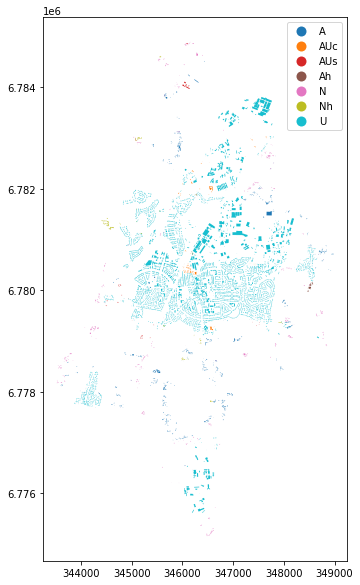

In [ ]:
# Encrichir les batiments des informations de la couche PLU (jointure spatiale)

BatimentsPLU = gpd.sjoin(Batiments, PLUCesson)
BatimentsPLU.plot(figsize=(10,10),column='typezone', legend=True)
BatimentsPLU.head(2)

In [ ]:
# Graphique du nombre de bâtiments par zonage

Categorie = BatimentsPLU[["typezone", "ID_Bati"]].groupby("typezone").count()
Categorie.plot.pie(figsize =(14,5), y="ID_Bati" )
Categorie.head()


KeyError: ignored

# Applicatif département

### Préparation des données


In [153]:
#Téléchargement des datas depuis cadastre.data.gouv

!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/batiments -O batiments.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/communes -O communes.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/sections -O sections.zip

--2023-03-18 10:18:52--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/batiments
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16347180 (16M) [application/x-shapefile]
Saving to: ‘batiments.zip’

batiments.zip       100%[===================>]  15.59M  8.83MB/s    in 1.8s    

2023-03-18 10:18:55 (8.83 MB/s) - ‘batiments.zip’ saved [16347180/16347180]

--2023-03-18 10:18:55--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/communes
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2052035 (2.0M) [application/x-shapefile]
Saving to: ‘communes.zip’

communes.zip        100%[===================>]   1

In [154]:
#Chargement couche batiment (environ 3mn)
batiments= gpd.read_file("batiments.zip")
batiments.head(3)

,commune,nom,type,created,updated,geometry
0,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1006989.398 6420372.597, 1006995.599..."
1,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1006815.000 6420560.191, 1006819.047..."
2,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1007869.496 6418963.664, 1007871.100..."


In [155]:
batiments['commune'].count()

168333

In [156]:
#Chargement couche communes
communes= gpd.read_file("communes.zip", encoding='utf-8')
communes.head(3)

,id,nom,created,updated,geometry
0,05003,AIGUILLES,2006-12-14,2017-03-17,"POLYGON ((1009588.427 6411890.754, 1009510.401..."
1,05018,LA BATIE-VIEILLE,2007-03-09,2019-07-02,"POLYGON ((950898.468 6385985.734, 950894.352 6..."
2,05025,BUISSARD,2008-04-17,2022-03-09,"POLYGON ((950232.638 6399301.150, 950040.131 6..."


In [157]:
len(communes)

162

In [158]:
#Chargement couche sections
sections= gpd.read_file("sections.zip", encoding='utf-8')
sections.head(3)

,id,commune,prefixe,code,created,updated,geometry
0,050010000A,05001,000,A,2006-11-01,2019-12-03,"POLYGON ((1007707.451 6418595.634, 1007710.400..."
1,050010000B,05001,000,B,2006-11-01,2019-12-03,"POLYGON ((1009315.792 6418632.565, 1009315.177..."
2,050030000A,05003,000,A,2006-11-26,2014-02-14,"POLYGON ((1004822.834 6418680.779, 1004820.601..."


In [159]:
len(sections)

1556

In [160]:
# Ajouter des index spatiaux aux couches

batiments.sindex
communes.sindex
sections.sindex

### Exercice à l'échelle des communes


In [161]:
# Calculer la surface des bâtiments

batiments["Surface_batiments"] = batiments['geometry'].area
batiments['Surface_batiments']=batiments['Surface_batiments'].astype(int)
batiments.head()

,commune,nom,type,created,updated,geometry,Surface_batiments
0,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1006989.398 6420372.597, 1006995.599...",32
1,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1006815.000 6420560.191, 1006819.047...",29
2,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1007869.496 6418963.664, 1007871.100...",135
3,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1007985.824 6418916.451, 1007989.503...",39
4,05001,NaN,01,2006-11-01,2019-12-03,"POLYGON ((1007865.693 6418968.847, 1007859.628...",59


In [162]:
# Calculer la somme des surfaces des bâtiments par commune

SurfaceBatisCommunes = batiments.groupby('commune').agg({'Surface_batiments':'sum'})
SurfaceBatisCommunes.head()

,Surface_batiments
commune,
05001,71846
05003,50215
05004,167479
05006,200459
05007,81246


In [163]:
# Calculer la surface des communes

communes["Surface_commune"] = communes['geometry'].area
communes["Surface_commune"]= communes["Surface_commune"].astype(int)
communes.head()

,id,nom,created,updated,geometry,Surface_commune
0,05003,AIGUILLES,2006-12-14,2017-03-17,"POLYGON ((1009588.427 6411890.754, 1009510.401...",40961501
1,05018,LA BATIE-VIEILLE,2007-03-09,2019-07-02,"POLYGON ((950898.468 6385985.734, 950894.352 6...",9064768
2,05025,BUISSARD,2008-04-17,2022-03-09,"POLYGON ((950232.638 6399301.150, 950040.131 6...",2937409
3,05037,CHATEAUVIEUX,2006-10-16,2022-08-05,"POLYGON ((942776.970 6378561.281, 942753.898 6...",7188870
4,05046,EMBRUN,2006-12-19,2019-04-03,"POLYGON ((977737.159 6388707.825, 977683.478 6...",36480523


In [164]:
# Jointure attributaire pour enrichir la couche des communes

communes = communes.merge(SurfaceBatisCommunes,left_on='id', right_on='commune')
communes.head()

,id,nom,created,updated,geometry,Surface_commune,Surface_batiments
0,05003,AIGUILLES,2006-12-14,2017-03-17,"POLYGON ((1009588.427 6411890.754, 1009510.401...",40961501,50215
1,05018,LA BATIE-VIEILLE,2007-03-09,2019-07-02,"POLYGON ((950898.468 6385985.734, 950894.352 6...",9064768,46466
2,05025,BUISSARD,2008-04-17,2022-03-09,"POLYGON ((950232.638 6399301.150, 950040.131 6...",2937409,26349
3,05037,CHATEAUVIEUX,2006-10-16,2022-08-05,"POLYGON ((942776.970 6378561.281, 942753.898 6...",7188870,79071
4,05046,EMBRUN,2006-12-19,2019-04-03,"POLYGON ((977737.159 6388707.825, 977683.478 6...",36480523,475744


In [165]:
# Créer l'indicateur de tx de recouvrement des batimenst

communes["indic"] = communes["Surface_batiments"] / communes["Surface_commune"]*100
communes.head(3)

,id,nom,created,updated,geometry,Surface_commune,Surface_batiments,indic
0,05003,AIGUILLES,2006-12-14,2017-03-17,"POLYGON ((1009588.427 6411890.754, 1009510.401...",40961501,50215,0.122591
1,05018,LA BATIE-VIEILLE,2007-03-09,2019-07-02,"POLYGON ((950898.468 6385985.734, 950894.352 6...",9064768,46466,0.512600
2,05025,BUISSARD,2008-04-17,2022-03-09,"POLYGON ((950232.638 6399301.150, 950040.131 6...",2937409,26349,0.897015


Text(0.0, 1.0, 'Taux de recouvrement des bâtiments dans le 35')

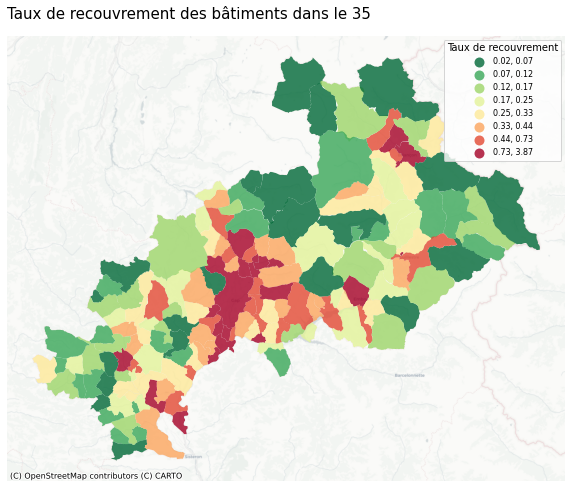

In [166]:
# Faire la carte

Carte1, ax = plt.pyplot.subplots(figsize=(10,10))

communes.to_crs('EPSG:3857').plot(ax=ax, k=8, column="indic", cmap='RdYlGn_r',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Taux de recouvrement", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax.axis("off")
plt.pyplot.title("Taux de recouvrement des bâtiments dans le 35", loc='left', fontsize=15)


### Exercice à l'échelle des sections cadastrale


In [167]:
# Calculer la surface des sections

sections["Surface_sections"] = sections['geometry'].area
sections["Surface_sections"]= sections["Surface_sections"].astype(int)
sections.head()

,id,commune,prefixe,code,created,updated,geometry,Surface_sections
0,050010000A,05001,000,A,2006-11-01,2019-12-03,"POLYGON ((1007707.451 6418595.634, 1007710.400...",12839552
1,050010000B,05001,000,B,2006-11-01,2019-12-03,"POLYGON ((1009315.792 6418632.565, 1009315.177...",1610471
2,050030000A,05003,000,A,2006-11-26,2014-02-14,"POLYGON ((1004822.834 6418680.779, 1004820.601...",5100321
3,050040000A,05004,000,A,2017-04-14,2017-05-23,"POLYGON ((952035.688 6396444.305, 952026.181 6...",2581147
4,050060000A,05006,000,A,2016-09-21,2017-05-23,"POLYGON ((968903.758 6414486.780, 968869.928 6...",13200604


In [168]:
# Faire la jointure spatiale entre les batiments et les sections

BatimentsCentro = batiments.copy()
BatimentsCentro.geometry = BatimentsCentro['geometry'].centroid

Batimentssections = gpd.sjoin(BatimentsCentro, sections)
Batimentssections.head(3)

,commune_left,nom,type,created_left,updated_left,geometry,Surface_batiments,index_right,id,commune_right,prefixe,code,created_right,updated_right,Surface_sections
0,05001,NaN,01,2006-11-01,2019-12-03,POINT (1006992.321 6420369.686),32,0,050010000A,05001,000,A,2006-11-01,2019-12-03,12839552
1,05001,NaN,01,2006-11-01,2019-12-03,POINT (1006818.821 6420560.484),29,0,050010000A,05001,000,A,2006-11-01,2019-12-03,12839552
2,05001,NaN,01,2006-11-01,2019-12-03,POINT (1007868.325 6418958.791),135,0,050010000A,05001,000,A,2006-11-01,2019-12-03,12839552


In [169]:
# Calculer la somme des surfaces des bâtiments par sections cadastrales

SurfaceBatisSections= Batimentssections.groupby('id').agg({'Surface_batiments':'sum'})
SurfaceBatisSections.head()

,Surface_batiments
id,
050010000A,615
050010000B,142
050010000C,193
050010000D,4999
050010000E,165


In [170]:
# Jointure attributaire pour enrichir la couche des communes

sections = sections.merge(SurfaceBatisSections,left_on='id', right_on='id')
sections.head()

,id,commune,prefixe,code,created,updated,geometry,Surface_sections,Surface_batiments
0,050010000A,05001,000,A,2006-11-01,2019-12-03,"POLYGON ((1007707.451 6418595.634, 1007710.400...",12839552,615
1,050010000B,05001,000,B,2006-11-01,2019-12-03,"POLYGON ((1009315.792 6418632.565, 1009315.177...",1610471,142
2,050030000A,05003,000,A,2006-11-26,2014-02-14,"POLYGON ((1004822.834 6418680.779, 1004820.601...",5100321,401
3,050040000A,05004,000,A,2017-04-14,2017-05-23,"POLYGON ((952035.688 6396444.305, 952026.181 6...",2581147,23070
4,050060000A,05006,000,A,2016-09-21,2017-05-23,"POLYGON ((968903.758 6414486.780, 968869.928 6...",13200604,226


In [171]:
# Créer l'indicateur de tx de recouvrement des batimenst

sections["indic"] = sections["Surface_batiments"] / sections["Surface_sections"]*100
sections.head(3)

,id,commune,prefixe,code,created,updated,geometry,Surface_sections,Surface_batiments,indic
0,050010000A,05001,000,A,2006-11-01,2019-12-03,"POLYGON ((1007707.451 6418595.634, 1007710.400...",12839552,615,0.004790
1,050010000B,05001,000,B,2006-11-01,2019-12-03,"POLYGON ((1009315.792 6418632.565, 1009315.177...",1610471,142,0.008817
2,050030000A,05003,000,A,2006-11-26,2014-02-14,"POLYGON ((1004822.834 6418680.779, 1004820.601...",5100321,401,0.007862


Text(0.0, 1.0, 'Taux de recouvrement des bâtiments dans le 35')

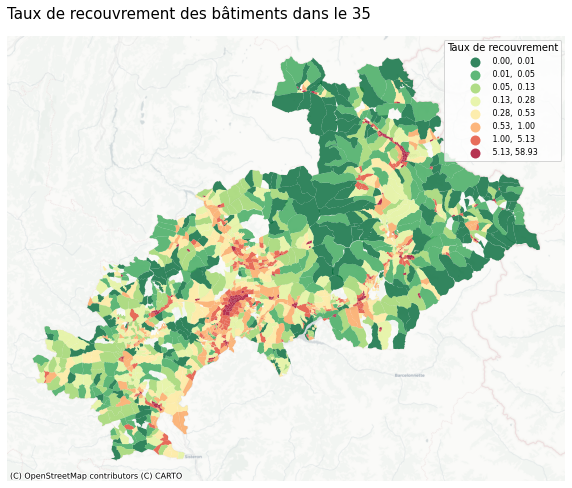

In [172]:
# Faire la carte

Carte1, ax = plt.pyplot.subplots(figsize=(10,10))

sections.to_crs('EPSG:3857').plot(ax=ax, k=8, column="indic", cmap='RdYlGn_r',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Taux de recouvrement", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax.axis("off")
plt.pyplot.title("Taux de recouvrement des bâtiments dans le 35", loc='left', fontsize=15)
